In [166]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss

In [167]:
s = np.fromfile('./inb14_fragment.bin', dtype='float32')
T = 600
Fs = 128
nyq_f = Fs/2
t = np.arange(0,T,1/Fs)

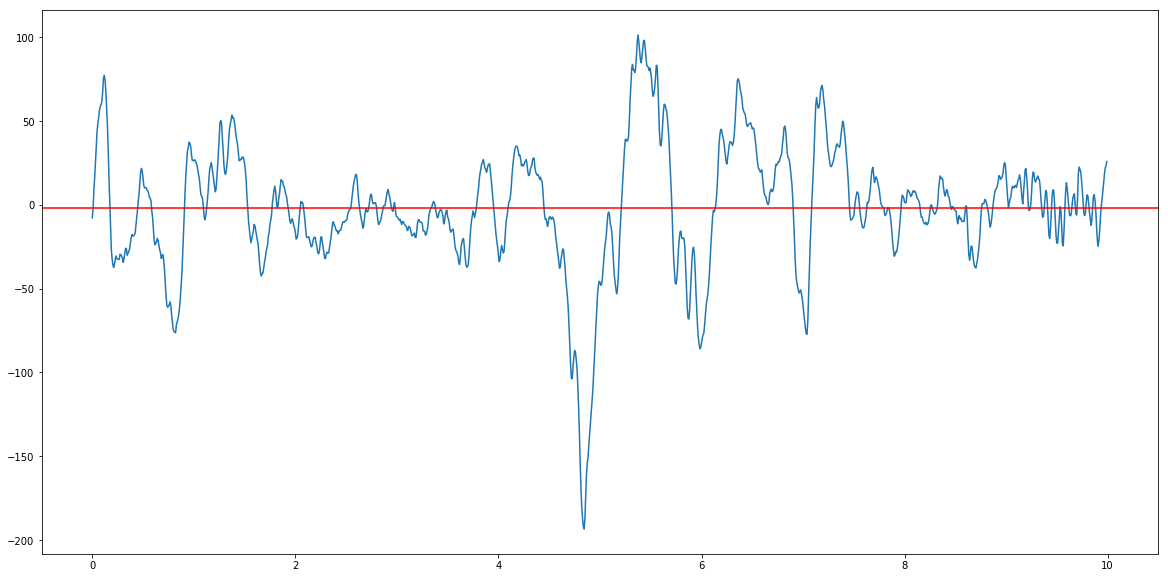

In [168]:
window = Fs*10
plt.figure(figsize=((20,10)))
plt.plot(t[:window], s[:window])
plt.axhline(np.mean(s[:window]), c='r')
plt.show()

### Pierwszy klasyfikator:

* filtruj sygnał filtrem pasmowo-przepustowym w paśmie 11-16 Hz
* przefiltrowany sygnał podnieś do kwadratu i przefiltruj filtrem dolnoprzepustowym z częstością odcięcia 10 Hz
* spierwiastkuj uzyskany sygnał
* wyszukaj momenty, w których sygnał ten przekracza wartość 5 mikroVoltów na okresy dłuższe niż 0.5 s.
* te okresy to wyszukane tą techniką wrzeciona

In [169]:
N = 7
Wn = (11/nyq_f, 16/nyq_f)
[b,a] = ss.butter(N, Wn, btype='bandpass')

In [170]:
s_1 = ss.filtfilt(b,a,s)
s_1 *= s_1

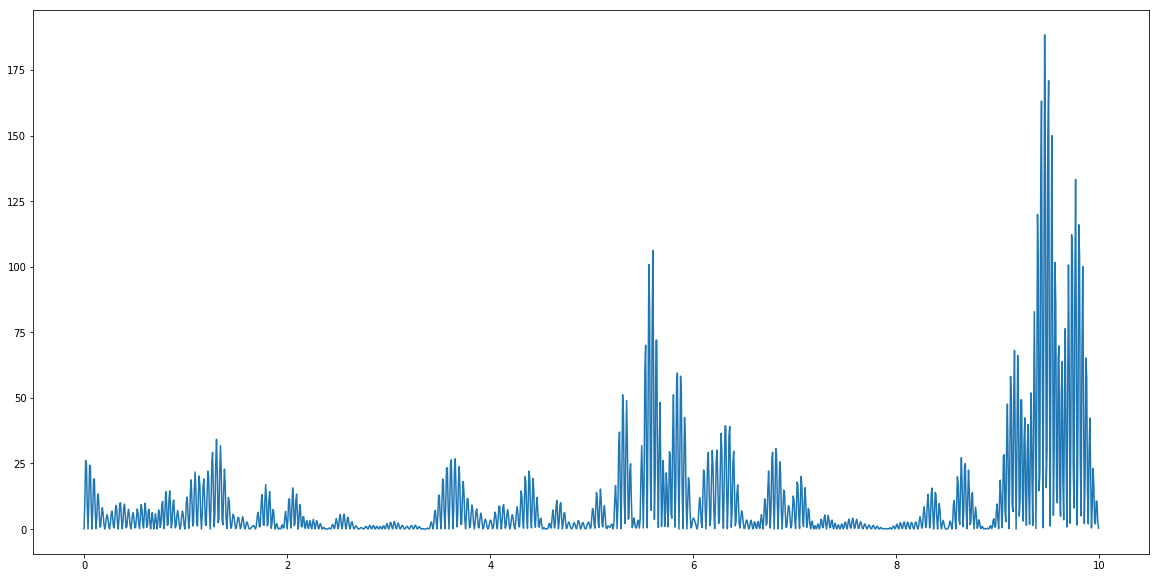

In [175]:
plt.figure(figsize=((20,10)))
plt.plot(t[:window], s_1[:window])
plt.show()

In [176]:
N = 7
Wn = 10/nyq_f
[b,a] = ss.butter(N, Wn, btype='lowpass')

In [177]:
s_2 = ss.filtfilt(b,a,s_1)
s_2 = s_2 ** .5

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


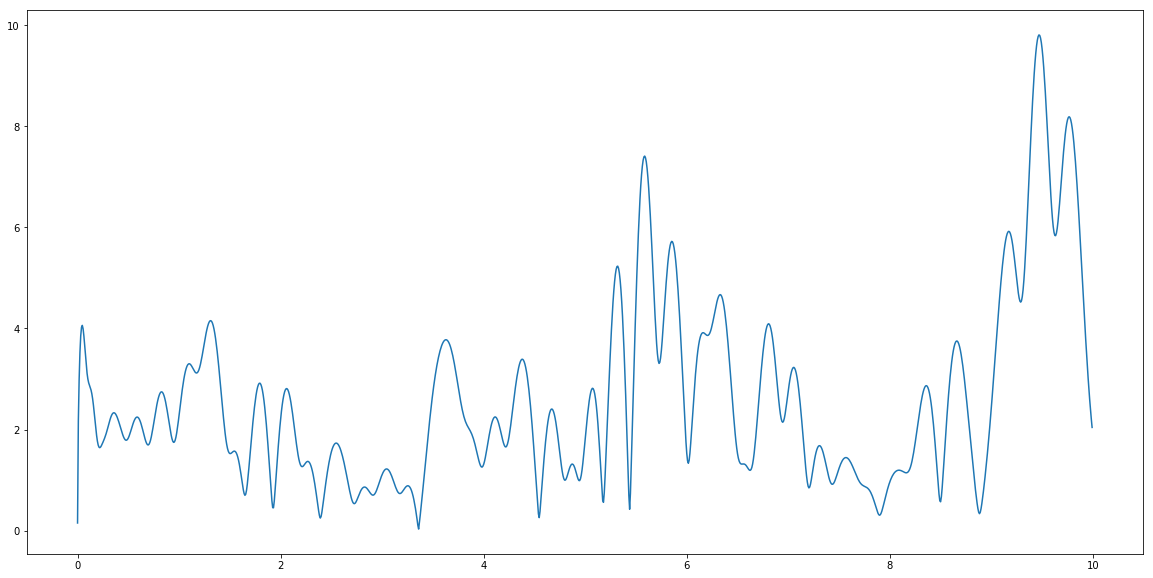

In [178]:
plt.figure(figsize=((20,10)))
plt.plot(t[:window], s_2[:window])
plt.show()

In [179]:
s_2[s_2 < 5] = 0
s_2[s_2 > 5] = 1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


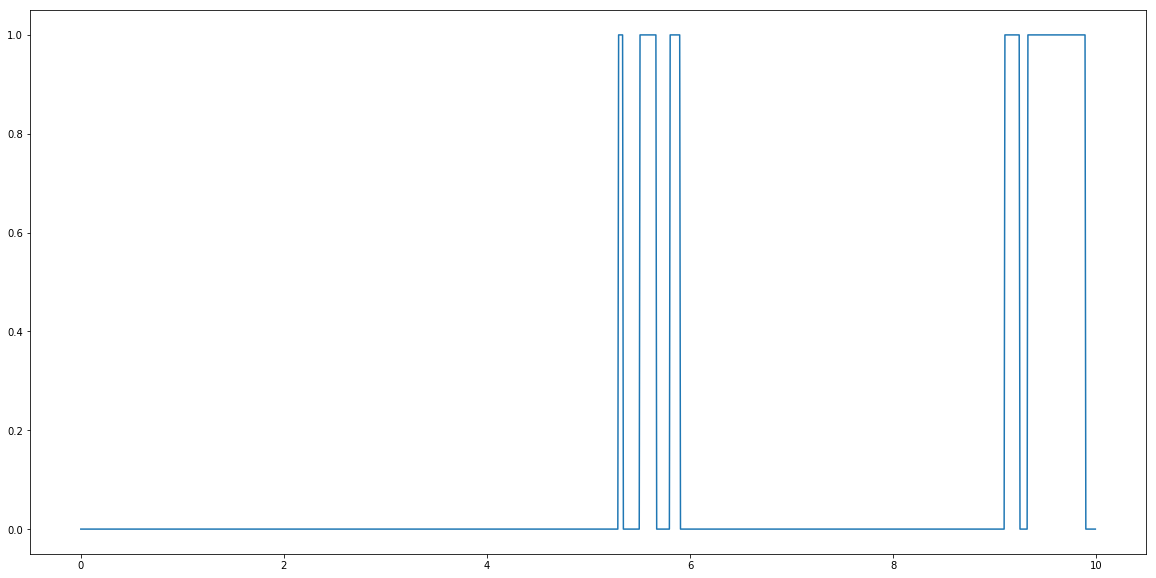

In [181]:
plt.figure(figsize=((20,10)))
plt.plot(t[:window], s_2[:window])
plt.show()

In [118]:
min_t = 0.5
min_elements = int(min_t * Fs)

length = len(s_2) - min_elements
wrzeciona = []
for i in range(0, length):
    total = np.sum(s_2[i:i+min_elements])
    ratio = total/min_elements
    if ratio == 1:
        wrzeciona.append(i)

In [138]:
prev = wrzeciona[0]
array = [wrzeciona[0]]
for w in wrzeciona:
    if w - prev > 1:
        array.append(prev + min_elements - 1)
        array.append(w)
    prev = w
array.append(wrzeciona[-1] + min_elements - 1)
array = np.array(array)
shape = array.shape[0]
array = array.reshape(int(shape/2), 2)
print(array)
# the array has at pointer 0 the start point and pointer 1 the end point

[[ 1194  1266]
 [13110 13175]
 [15165 15252]
 [16711 16790]
 [28392 28456]
 [30003 30066]
 [39280 39391]
 [42359 42448]
 [45149 45256]
 [45583 45661]
 [45898 45999]
 [47190 47257]
 [48931 49043]
 [49931 49995]
 [50608 50678]
 [54439 54519]
 [58598 58665]
 [62708 62779]
 [64466 64534]
 [65056 65119]
 [69362 69430]
 [70679 70750]
 [74835 74944]]


In [145]:
# Transform to time
t_array = array / Fs
print(np.round(t_array, 2))

[[  9.33   9.89]
 [102.42 102.93]
 [118.48 119.16]
 [130.55 131.17]
 [221.81 222.31]
 [234.4  234.89]
 [306.88 307.74]
 [330.93 331.62]
 [352.73 353.56]
 [356.12 356.73]
 [358.58 359.37]
 [368.67 369.2 ]
 [382.27 383.15]
 [390.09 390.59]
 [395.38 395.92]
 [425.3  425.93]
 [457.8  458.32]
 [489.91 490.46]
 [503.64 504.17]
 [508.25 508.74]
 [541.89 542.42]
 [552.18 552.73]
 [584.65 585.5 ]]


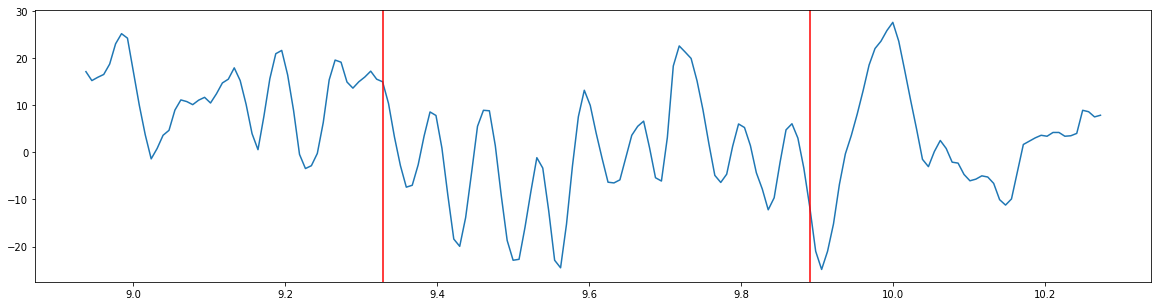

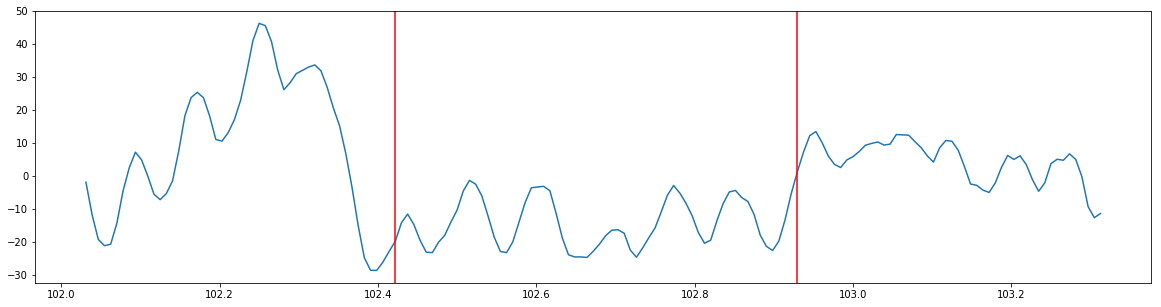

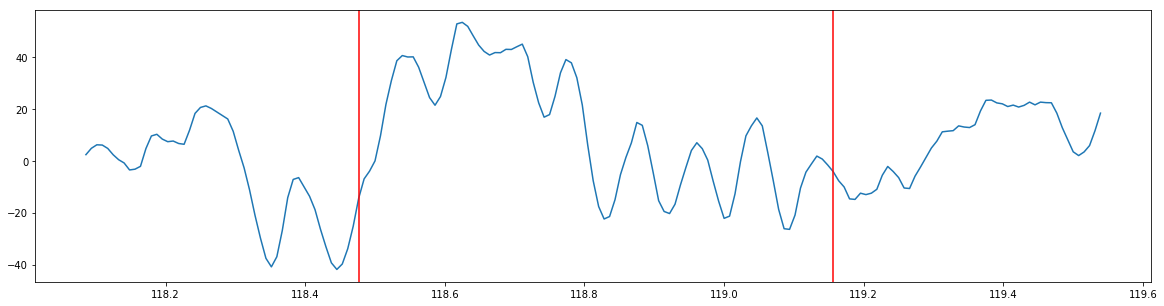

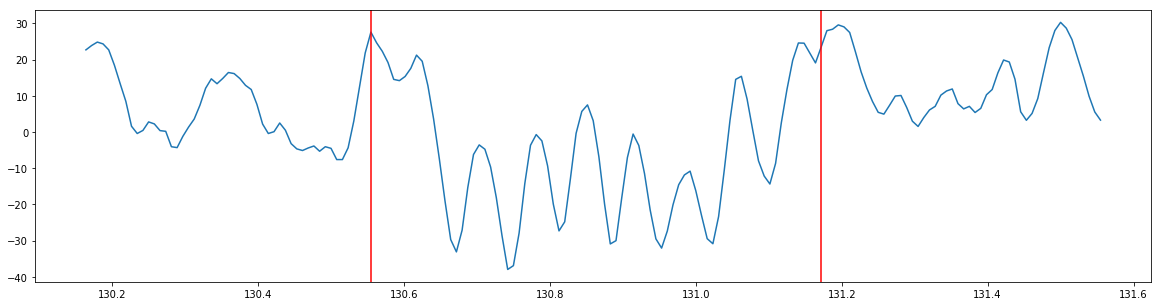

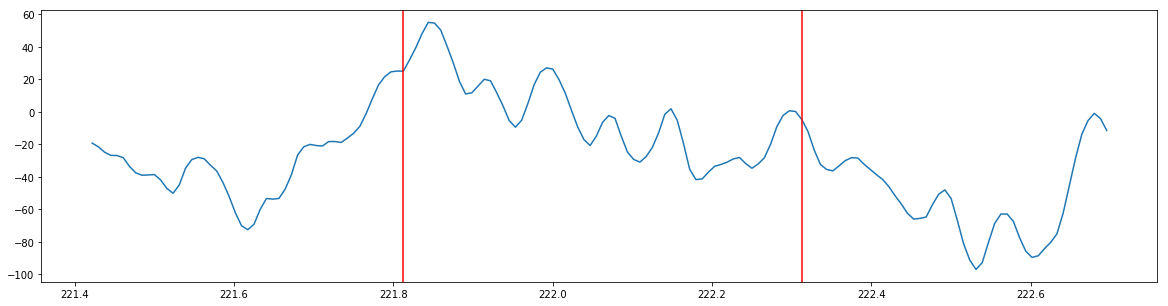

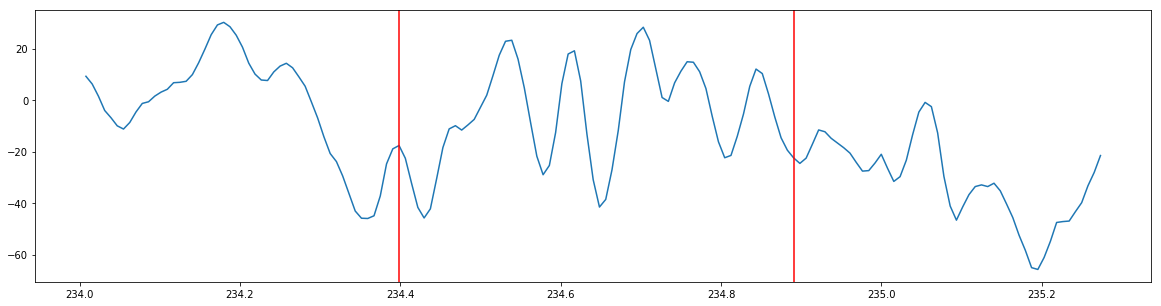

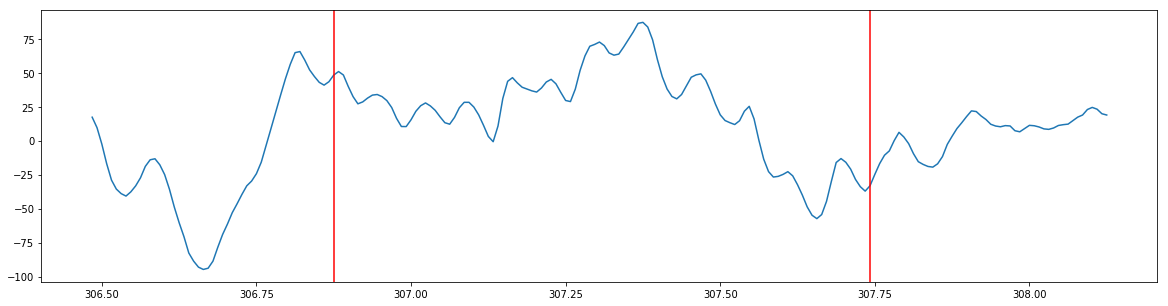

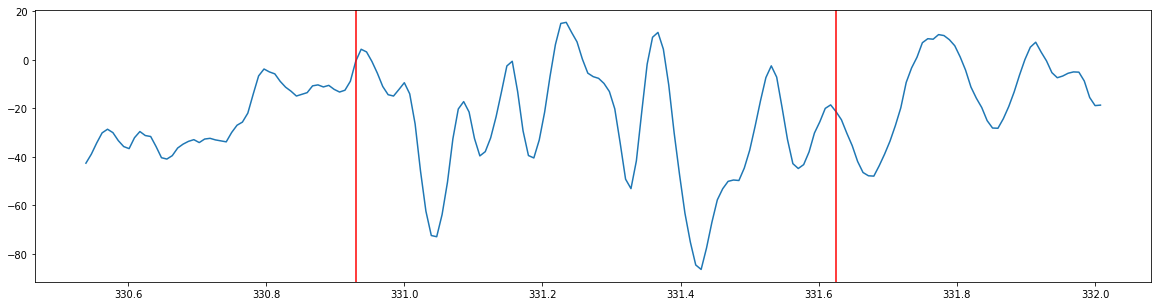

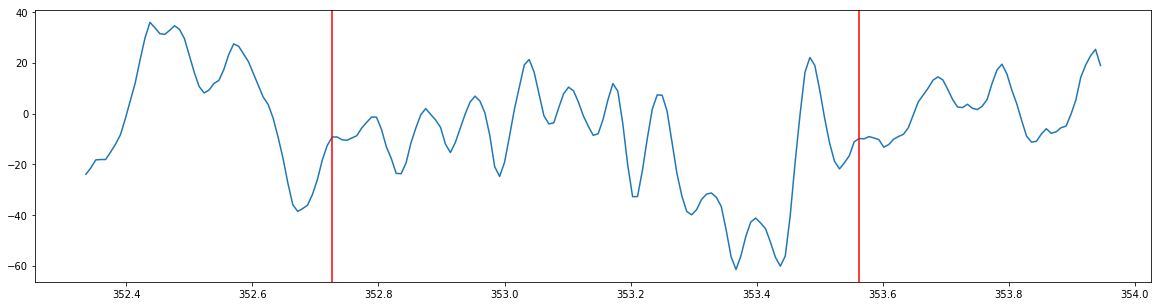

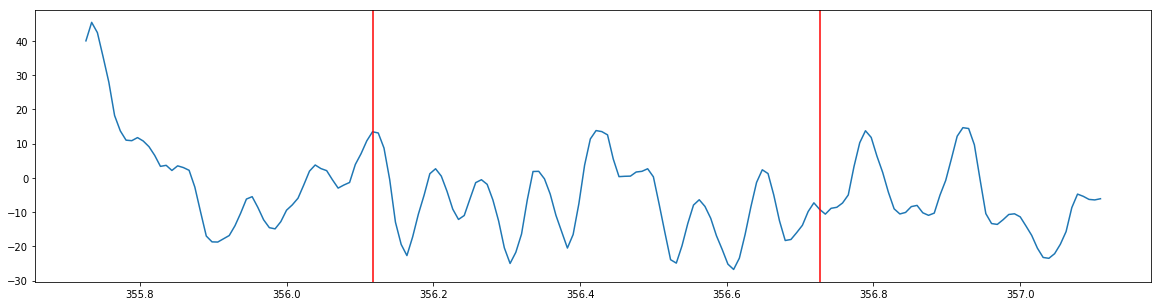

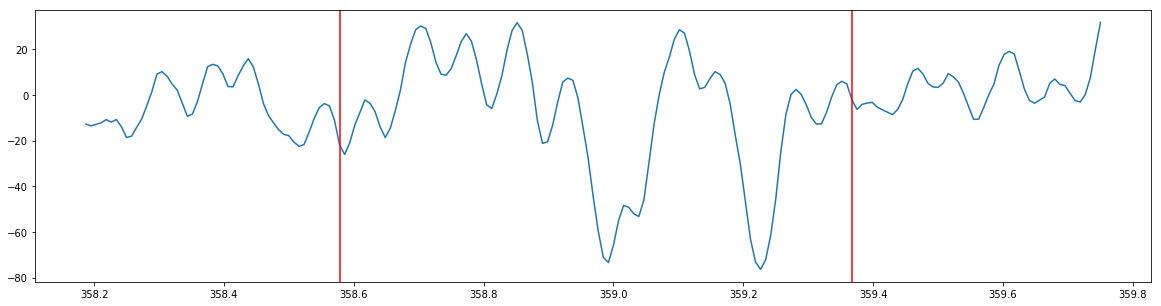

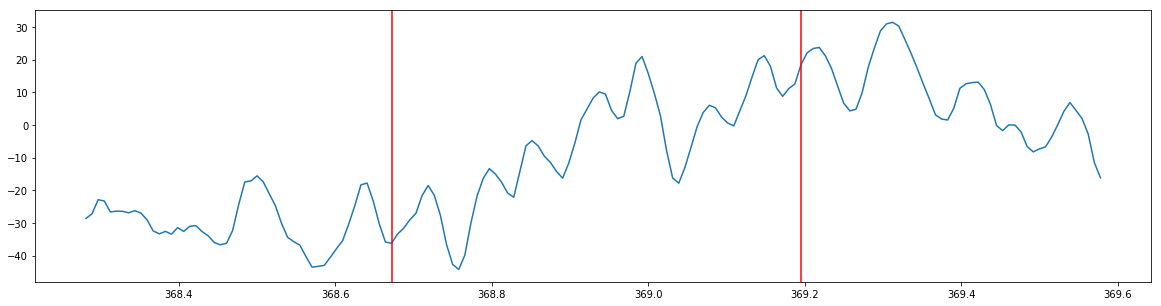

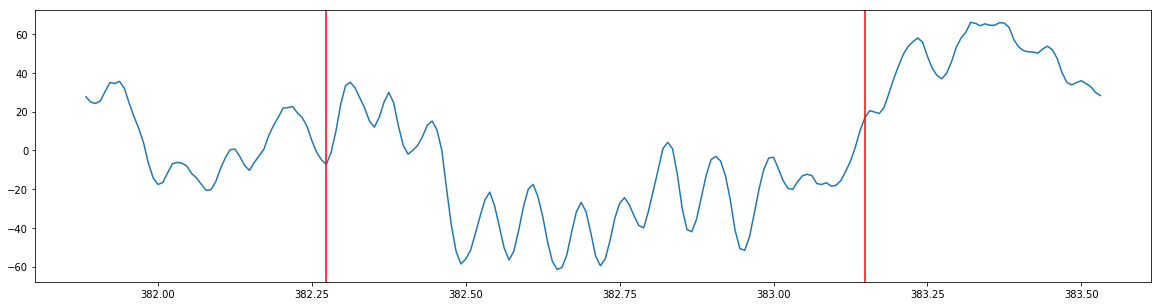

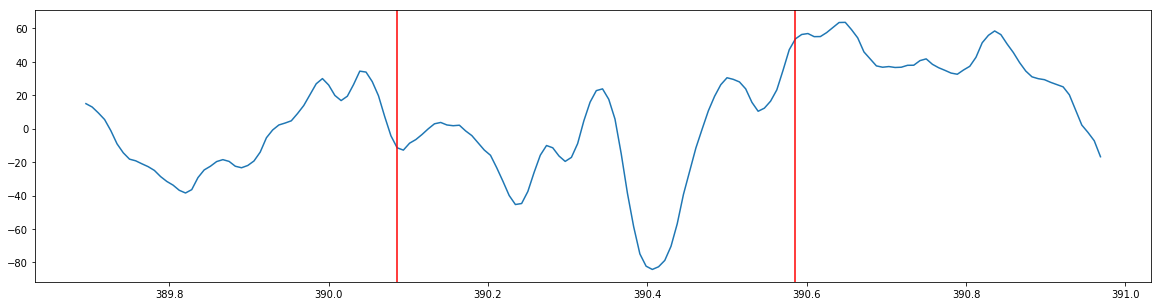

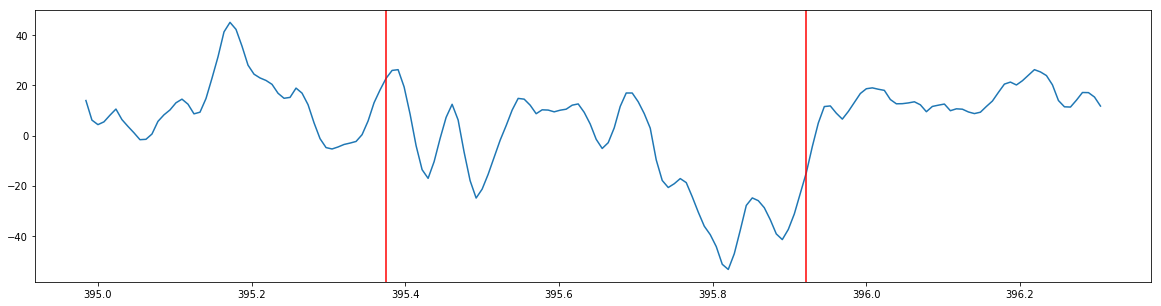

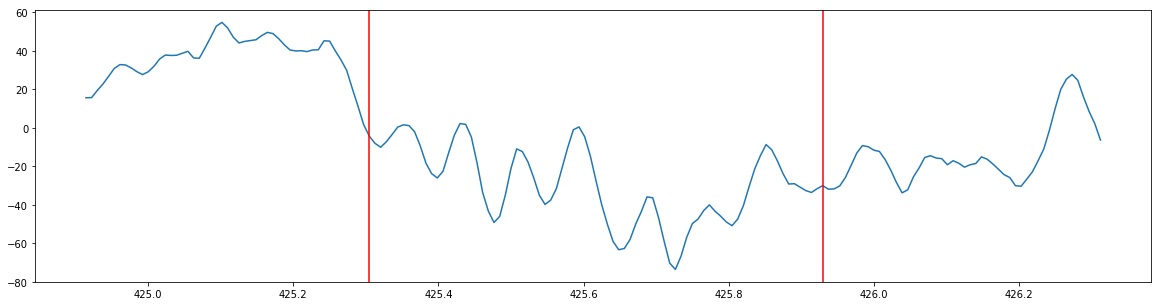

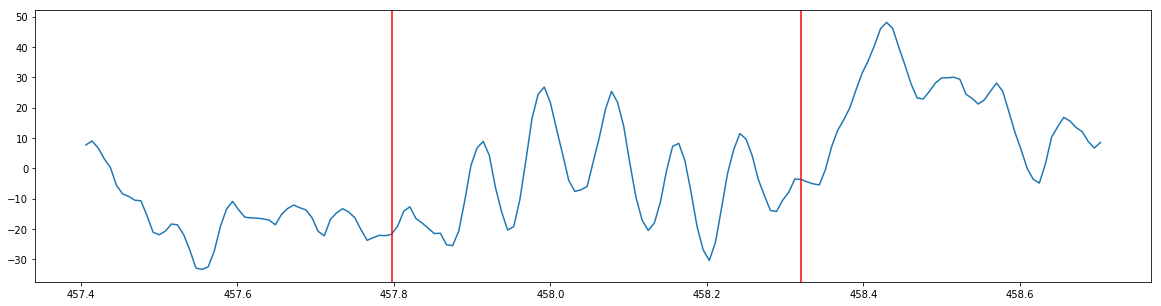

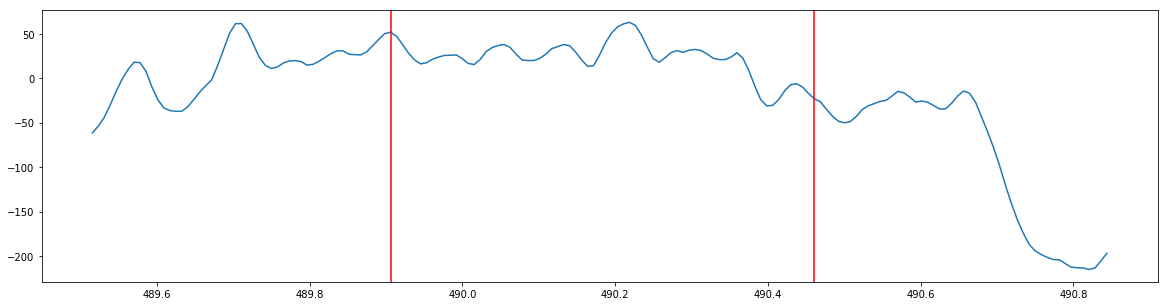

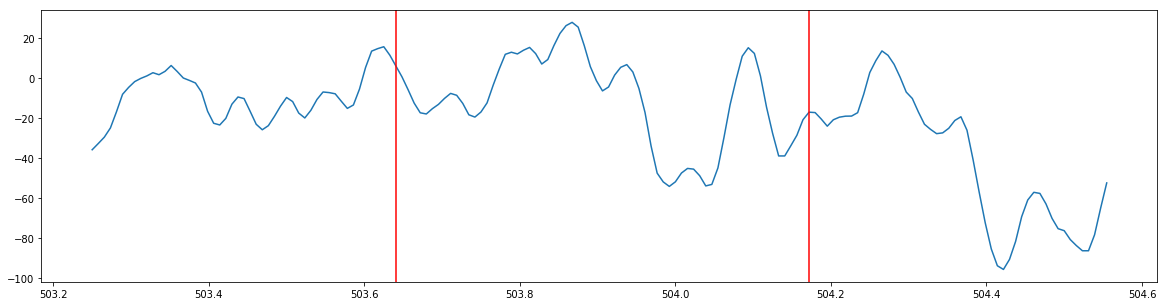

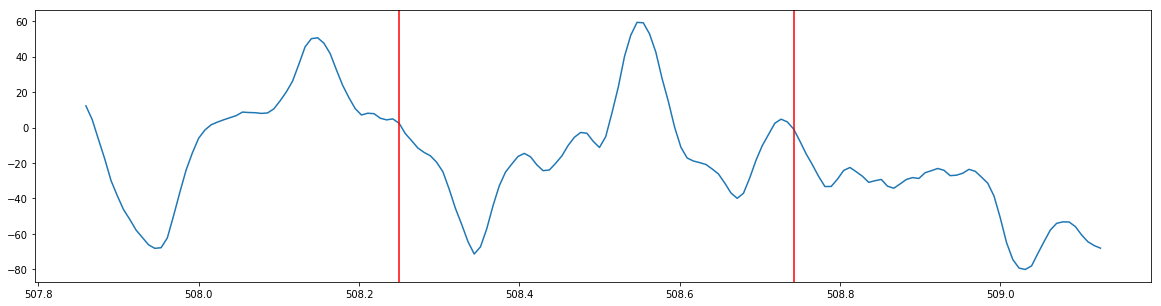

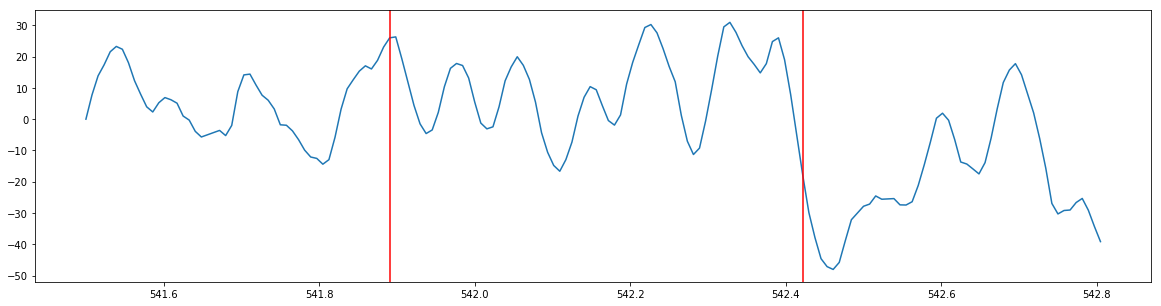

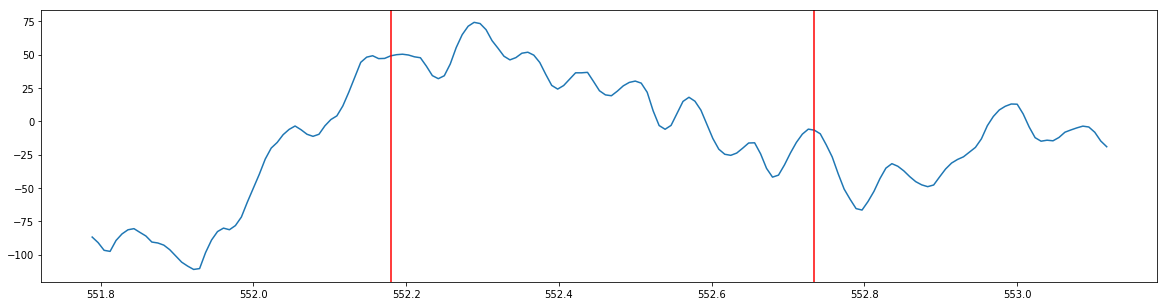

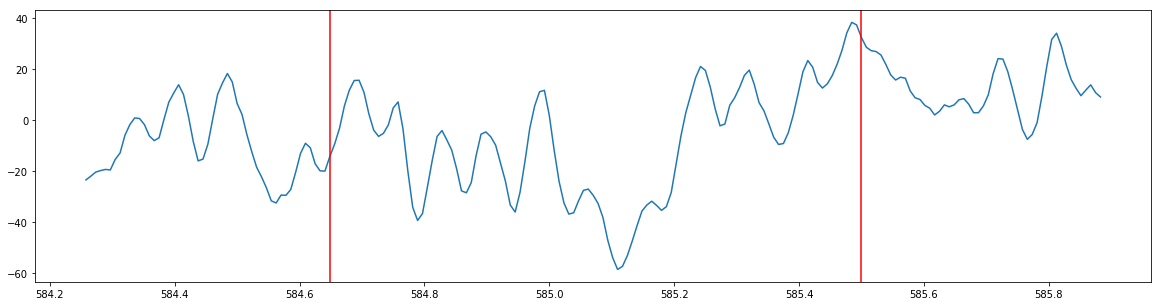

In [146]:
#lets plot those places so that we can see them
for i in array:
    plt.figure(figsize=((20,5)))
    plt.plot(t[i[0]-50:i[1]+50], s[i[0]-50:i[1]+50])
    plt.axvline(t[i[0]], c='r')
    plt.axvline(t[i[1]], c='r')
    plt.show()

## Drugi klasyfikator

* wykonaj dekompozycję MP sygnału dzielonego na 20 sek. epoki (30 epok). Więcej o dekompozycji MP w [2].
* wykonaj ją dla dwóch wartości parametrów 'energyError' = {0.1, 0.01}
* wymuś 50 iteracji na epokę
* wykonaj mapy czas-częstość na podstawie uzyskanych dekompozycji
* przeglądajac parametry atomów, wyszukaj te, które spełniają defnicję wrzeciona (częstość z przedziału 11-16 Hz, czas trwania>0.5 s).